Load Data: https://www.kaggle.com/rmisra/news-category-dataset/code?datasetId=32526&searchQuery=df+%3D+pd.read_json%28file_path%2C+lines+%3D+True%29

Main Code: https://www.kaggle.com/hengzheng/news-category-classifier-val-acc-0-65

RUS/ROS: https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/


In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/

/content/drive/MyDrive/Colab Notebooks


In [3]:
import pandas as pd
def load_data(file_path):
    df = pd.read_json(file_path, lines = True)
    df['category'] = pd.Categorical(df['category'])
    df = df[df["short_description"] != ""]
    df['headlineDesc'] = df['headline']+ ' ' + df['short_description']
    return df[["headlineDesc", "category"]]

df = load_data('News_Category_Dataset_v2.json')
df.head()

,headlineDesc,category
0,There Were 2 Mass Shootings In Texas Last Week...,CRIME
1,Will Smith Joins Diplo And Nicky Jam For The 2...,ENTERTAINMENT
2,Hugh Grant Marries For The First Time At Age 5...,ENTERTAINMENT
3,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,ENTERTAINMENT
4,Julianna Margulies Uses Donald Trump Poop Bags...,ENTERTAINMENT


In [4]:
#different than baseline (keras instead of spacy)
from keras.preprocessing.text import Tokenizer
# tokenizing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.headlineDesc)
X = tokenizer.texts_to_sequences(df.headlineDesc)
df['words'] = X
vocab_size = len(tokenizer.word_index) + 1
# delete some empty and short data
df['word_length'] = df.words.apply(lambda i: len(i))
df = df[df.word_length >= 5]
df.head()

,headlineDesc,category,words,word_length
0,There Were 2 Mass Shootings In Texas Last Week...,CRIME,"[72, 100, 269, 1339, 2992, 6, 719, 133, 99, 25...",27
1,Will Smith Joins Diplo And Nicky Jam For The 2...,ENTERTAINMENT,"[42, 1642, 3030, 29315, 5, 27163, 5247, 8, 1, ...",20
2,Hugh Grant Marries For The First Time At Age 5...,ENTERTAINMENT,"[5897, 5371, 8449, 8, 1, 77, 54, 21, 420, 8450...",25
3,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,ENTERTAINMENT,"[2786, 14389, 3767, 62936, 2342, 13028, 5, 578...",26
4,Julianna Margulies Uses Donald Trump Poop Bags...,ENTERTAINMENT,"[40141, 35327, 1541, 95, 45, 8344, 3148, 2, 94...",26


In [5]:
from keras.preprocessing import sequence
import numpy as np
maxlen = 50
X = list(sequence.pad_sequences(df.words, maxlen=maxlen))
categories = df.groupby('category').size().index.tolist()
category_int = {}
int_category = {}
for i, k in enumerate(categories):
    category_int.update({k:i})
    int_category.update({i:k})

df['c2id'] = df['category'].apply(lambda x: category_int[x])

word_index = tokenizer.word_index

EMBEDDING_DIM = 100

embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s unique tokens.' % len(word_index))
print('Total %s word vectors.' % len(embeddings_index))

Found 114348 unique tokens.
Total 400000 word vectors.


In [6]:
from keras import layers
from keras.initializers import Constant
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = layers.Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)

X = np.array(X)
Y = np_utils.to_categorical(list(df.c2id))

In [7]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X, Y = rus.fit_resample(X, Y)

In [8]:
# split to training set and validation set
seed = 1234
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=seed)

In [9]:
from keras.models import Sequential, Model
from keras.backend import clear_session
clear_session()

from tensorflow.keras import models
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
inp = layers.Input(shape=(maxlen,), dtype='int32')
embedding_layer = layers.Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)

## embedding
x = embedding_layer(inp)
## apply attention
x = attention_layer(x, neurons=50)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=50, dropout=0.5, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=50, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(41, activation='softmax')(x)
## compile
model = models.Model(inp, y_out)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 100)      11434900    ['input_1[0][0]']                
                                                                                                  
 permute (Permute)              (None, 100, 50)      0           ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 100, 50)      2550        ['permute[0][0]']                
                                                                                              

In [10]:
history = model.fit(x_train, y_train, epochs=40, batch_size=64, validation_data=(x_val, y_val))

Epoch 1/40
387/387 [==============================] - 74s 176ms/step - loss: 3.5130 - accuracy: 0.0590 - val_loss: 3.3036 - val_accuracy: 0.0900
Epoch 2/40
387/387 [==============================] - 63s 163ms/step - loss: 3.1845 - accuracy: 0.1244 - val_loss: 3.0335 - val_accuracy: 0.1541
Epoch 3/40
387/387 [==============================] - 63s 164ms/step - loss: 3.0010 - accuracy: 0.1655 - val_loss: 2.8842 - val_accuracy: 0.1864
Epoch 4/40
387/387 [==============================] - 63s 164ms/step - loss: 2.8629 - accuracy: 0.1883 - val_loss: 2.7573 - val_accuracy: 0.2156
Epoch 5/40
387/387 [==============================] - 64s 164ms/step - loss: 2.7761 - accuracy: 0.2110 - val_loss: 2.6382 - val_accuracy: 0.2487
Epoch 6/40
387/387 [==============================] - 63s 163ms/step - loss: 2.6787 - accuracy: 0.2346 - val_loss: 2.6127 - val_accuracy: 0.2576
Epoch 7/40
387/387 [==============================] - 64s 165ms/step - loss: 2.5960 - accuracy: 0.2547 - val_loss: 2.4534 - val_ac

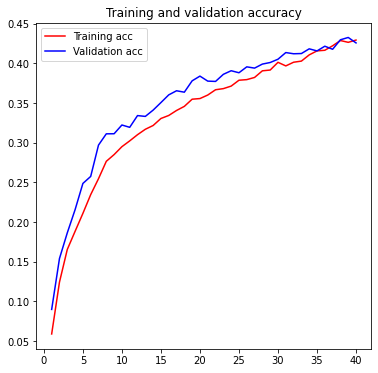

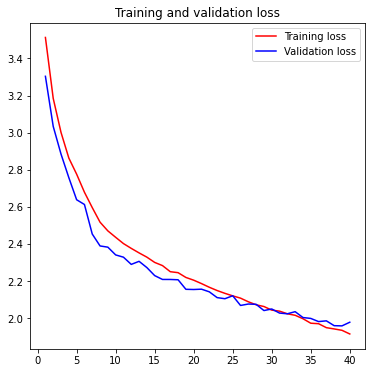

In [11]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6,6)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()

plt.show()

In [12]:
# Final evaluation of the model
scores = model.evaluate(x_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 42.58%
